In [1]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

In [2]:
blocksci.heuristics.coinjoin.input_one_hop

# Percentage of used scripts in time

Observe how the used scripts changed over time. All scripts using witnesses are in the `SegWit` category.

CPU times: user 9min 52s, sys: 14.5 s, total: 10min 7s
Wall time: 3.47 s


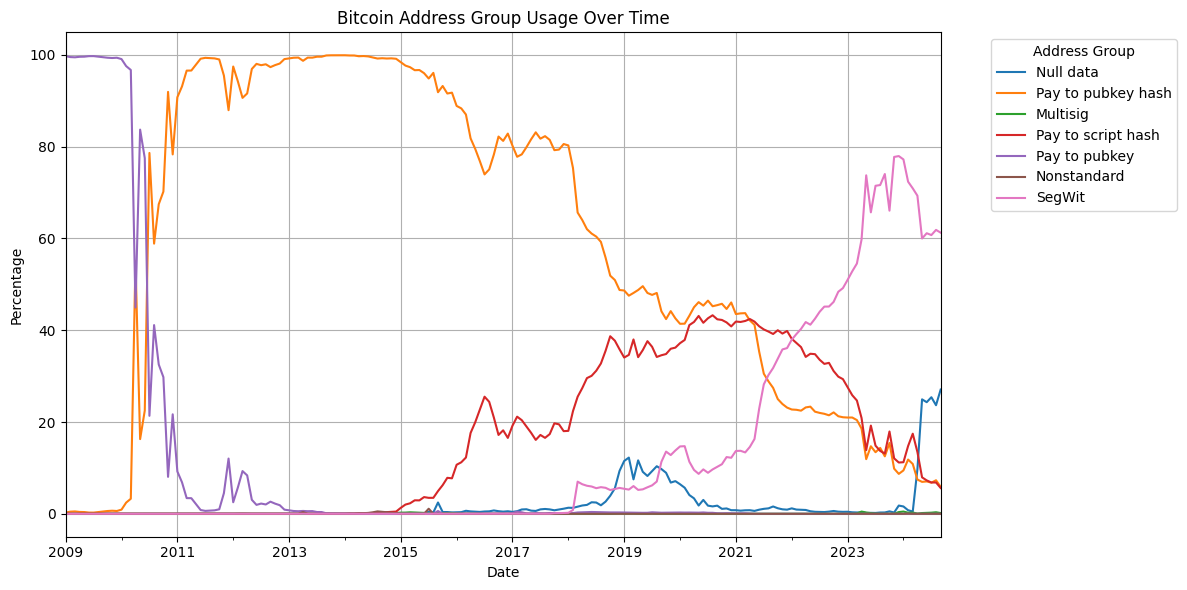

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%time data = chain.get_count_of_address_types_for_each_day(0, len(chain))


# Convert data to a flat DataFrame
df = pd.DataFrame.from_dict(data, orient='index')
df = df.fillna(0).T  # Transpose to make days the rows
df.index = pd.to_datetime(df.index.map(lambda x: datetime.utcfromtimestamp(x * 86400)))

# Define grouping of address types
group_mapping = {
    blocksci.address_type.witness_pubkeyhash: "segwit",
    blocksci.address_type.witness_unknown: "segwit",
    blocksci.address_type.witness_scripthash: "segwit",
}

# Aggregate the grouped categories
segwit_total = df[group_mapping.keys()].sum(axis=1)  # Sum up all segwit categories
df["SegWit"] = segwit_total  # Add as a new column

# Drop the original categories that were grouped
df = df.drop(columns=group_mapping.keys())

# Resample to larger bins (e.g., weekly bins)
df = df.resample('M').sum()

# Calculate total transactions per bin
df['total'] = df.sum(axis=1)

# Calculate percentages for each category
percentages = df.div(df['total'], axis=0) * 100
percentages = percentages.drop(columns=['total'])  # Drop the total column

# Plot the data
plt.figure(figsize=(12, 6))
percentages.plot(kind='line', ax=plt.gca())

# Move legend outside the graph
plt.legend(title='Address Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title and labels
plt.title('Bitcoin Address Group Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.grid()

# Adjust layout to accommodate the legend
plt.tight_layout()

# Show the plot
plt.show()


# CoinJoins


In [4]:
%time ww2_coinjoins = chain.filter_coinjoin_txes(0, len(chain), "ww2")
%time ww1_coinjoins = chain.filter_coinjoin_txes(0, len(chain), "ww1")
%time wp_coinjoins = chain.filter_coinjoin_txes(0, len(chain), "wp")
print(len(ww2_coinjoins), len(ww1_coinjoins), len(wp_coinjoins))

CPU times: user 1min 24s, sys: 232 ms, total: 1min 24s
Wall time: 724 ms
CPU times: user 2min 35s, sys: 340 ms, total: 2min 35s
Wall time: 2.3 s
CPU times: user 1min 32s, sys: 691 ms, total: 1min 33s
Wall time: 1.4 s
37316 34728 541107


## Number of coinjoins in the wild

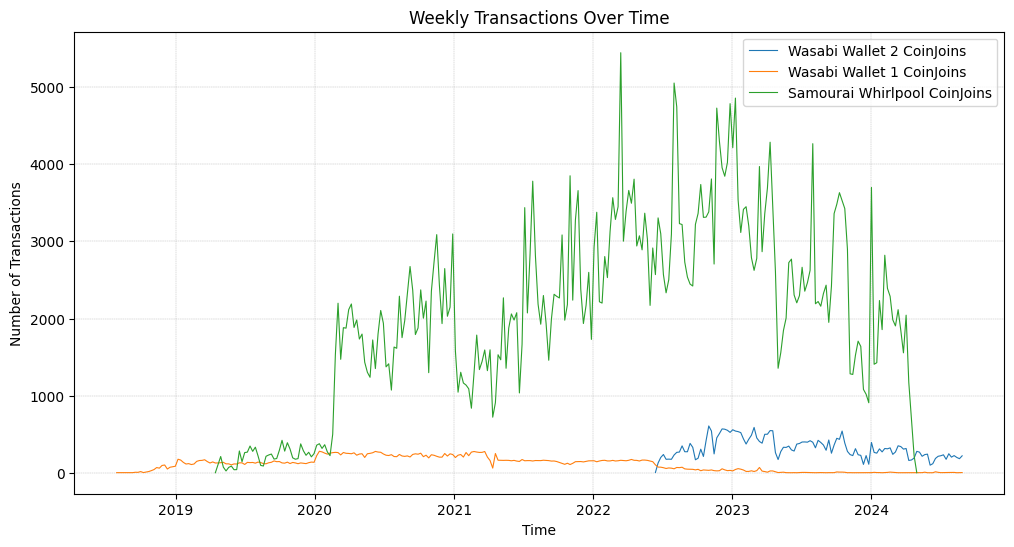

In [4]:
def process_transactions(transactions, label):
    transactions = list(map(lambda tx: {"block_time": tx.block_time}, transactions))
    df = pd.DataFrame(transactions)
    df['block_time'] = pd.to_datetime(df['block_time'])
    df['week'] = df['block_time'].dt.to_period('W').dt.to_timestamp()  # Get the timestamp for the start of the week
    weekly_counts = df.groupby('week').size()
    return weekly_counts, label

weekly_counts_ww2, label_1 = process_transactions(ww2_coinjoins, "Wasabi Wallet 2 CoinJoins")
weekly_counts_ww1, label_2 = process_transactions(ww1_coinjoins, "Wasabi Wallet 1 CoinJoins")
weekly_counts_wp, label_3 = process_transactions(wp_coinjoins, "Samourai Whirlpool CoinJoins")

plt.figure(figsize=(12, 6))

plt.plot(weekly_counts_ww2.index, weekly_counts_ww2.values, label=label_1, linewidth=0.8)
plt.plot(weekly_counts_ww1.index, weekly_counts_ww1.values, label=label_2, linewidth=0.8)
plt.plot(weekly_counts_wp.index, weekly_counts_wp.values, label=label_3, linewidth=0.8)

plt.title("Weekly Transactions Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Transactions")
plt.legend()

plt.grid(True, linestyle='--', linewidth=0.3)
plt.savefig("/mnt/blocksci/weekly_cjs_over_time.png")

plt.show()


## Liquidity

In [5]:
tx: blocksci.Tx
i: blocksci.Input
from collections import defaultdict
from datetime import datetime, timedelta

def process_input_liquidity(cjs, label):
    input_liquitidy_per_date = {}
    s = set(cjs)
    
    for tx in cjs:
        tx_date = tx.block_time.date()
        if tx_date not in input_liquitidy_per_date:
            input_liquitidy_per_date[tx_date] = 0
    
        for i in tx.inputs:
            if i.spent_tx in s:
                continue
    
            input_liquitidy_per_date[tx_date] += i.value

    sorted_liquidity = {k: v // 100000000 for k, v in sorted(input_liquitidy_per_date.items(), key=lambda t: t[0])}
    

    return sorted_liquidity, label

liq1, lab1 = process_input_liquidity(ww2_coinjoins, "Wasabi2 Input Liquidity")
liq2, lab2 = process_input_liquidity(ww1_coinjoins, "Wasabi1 Input Liquidity")
liq3, lab3 = process_input_liquidity(wp_coinjoins, "Whirlpool Input Liquidity")

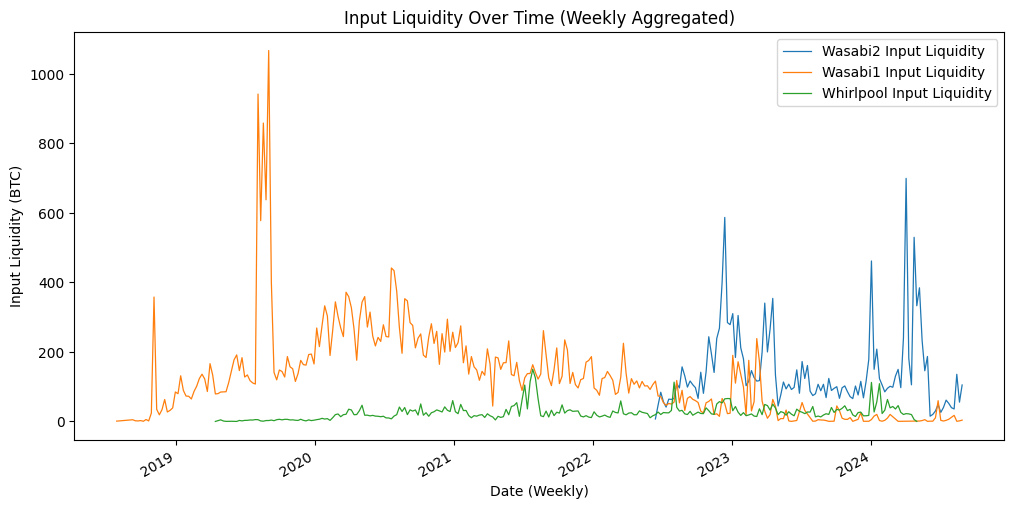

In [19]:
def group_by_week(data):
    weekly_data = defaultdict(int)
    for date, count in data.items():
        nd = datetime.combine(date, datetime.min.time())
        week_start = nd - timedelta(days=nd.weekday())
        weekly_data[week_start] += count

    for k in weekly_data:
        weekly_data[k] /= 7
    return dict(sorted(weekly_data.items()))

#weekly_data1 = liq1
#weekly_data2 = liq2
#weekly_data3 = liq3

weekly_data1 = group_by_week(liq1)
weekly_data2 = group_by_week(liq2)
weekly_data3 = group_by_week(liq3)


# Prepare dates and values for plotting
dates1, values1 = zip(*weekly_data1.items())
dates2, values2 = zip(*weekly_data2.items())
dates3, values3 = zip(*weekly_data3.items())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(dates1, values1, label=lab1, linewidth=0.9)
plt.plot(dates2, values2, label=lab2, linewidth=0.9)
plt.plot(dates3, values3, label=lab3, linewidth=0.9)

# Add labels, title, and legend
plt.xlabel("Date (Weekly)")
plt.ylabel("Input Liquidity (BTC)")
plt.title("Input Liquidity Over Time (Weekly Average)")
plt.legend()

# Improve date formatting on the x-axis
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()



## Traverses

In [2]:
one_random_wp_cj = chain.tx_with_hash("00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058")

%time traverses = chain.find_traverses_between_coinjoins(0, len(chain))

CPU times: user 26min 8s, sys: 48.7 s, total: 26min 57s
Wall time: 1min 46s


In [3]:
def cmp(cjt1, cjt2):
    return int(cjt1) < int(cjt2)

blocksci.CoinJoinType.__lt__ = cmp

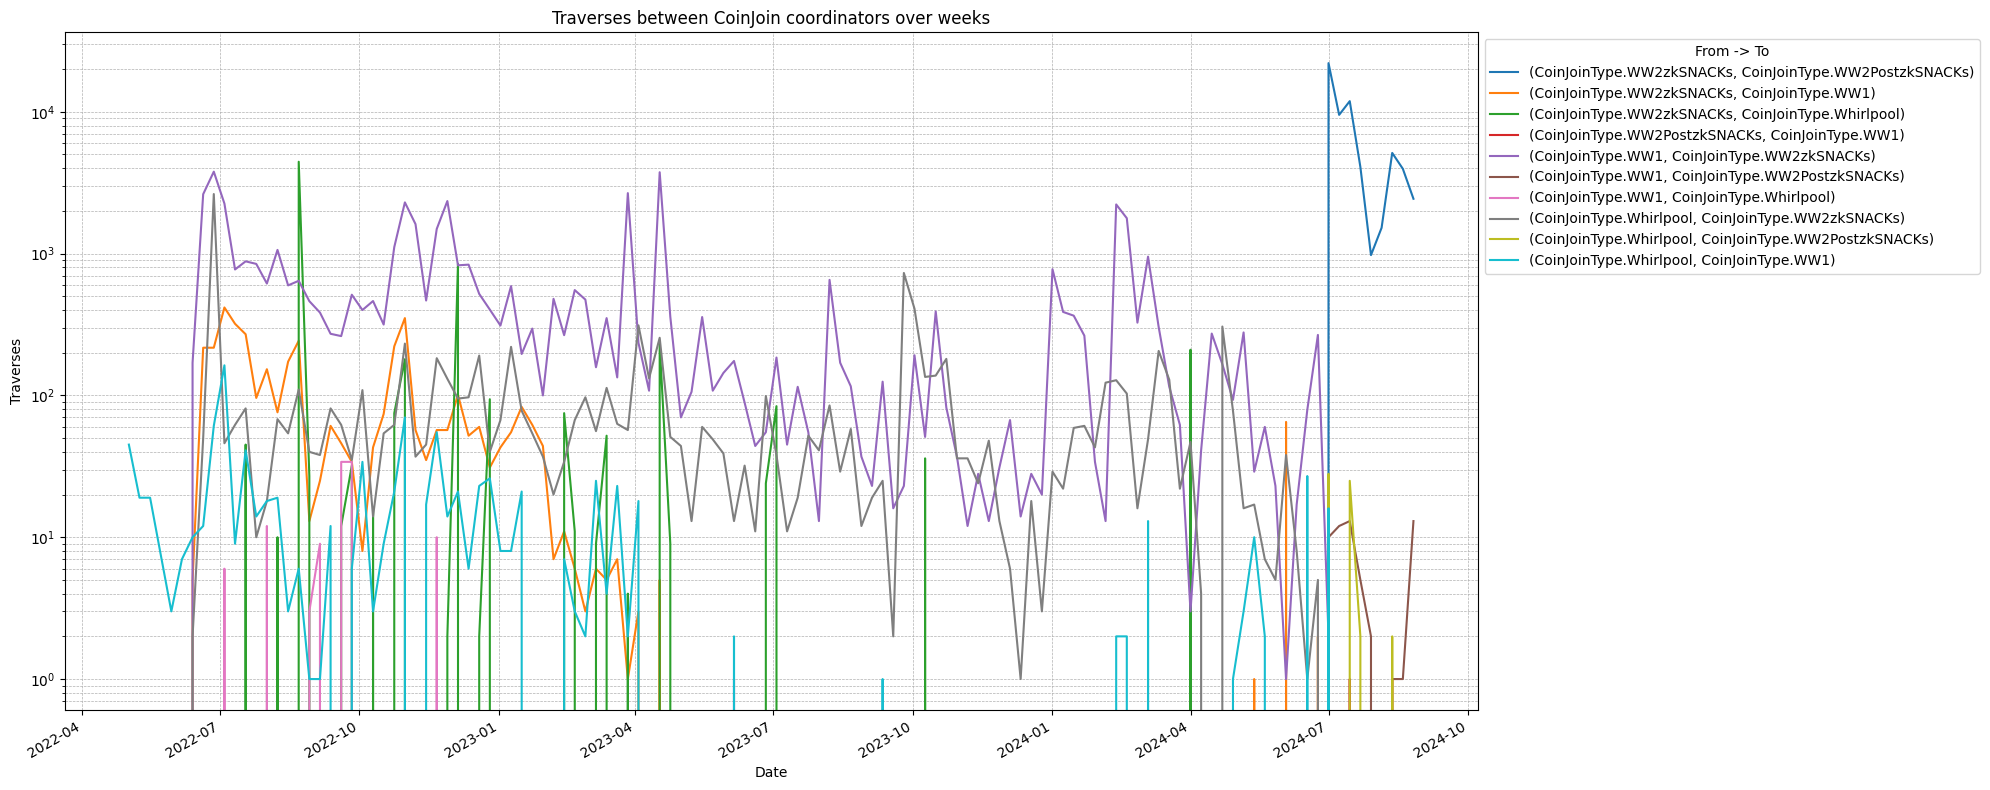

In [4]:
import datetime

# flatten and convert to enums
records = []
for dt, from_map in traverses.items():
    for from_cj, to_map in from_map.items():
        for to_cj, count in to_map.items():
            time = chain[dt].time
            # non-relevant values before this date
            if time < datetime.datetime(2022, 5, 1):
                continue
            records.append({"datetime": time, "from_cj": blocksci.CoinJoinType(from_cj), "to_cj": blocksci.CoinJoinType(to_cj), "count": count})

df = pd.DataFrame(records)
df['datetime'] = pd.to_datetime(df['datetime'])

# aggregate over weeks
df['week'] = df['datetime'].dt.to_period('W').apply(lambda x: x.start_time)

# get all unique values over weeks
unique_weeks = df['week'].unique()
unique_from_cj = df['from_cj'].unique()
unique_to_cj = df['to_cj'].unique()

# create an index in the DF for the cartesian product of all unique from->to values over weeks
full_index = pd.MultiIndex.from_product(
    [unique_weeks, unique_from_cj, unique_to_cj],
    names=["week", "from_cj", "to_cj"]
)

# Reindex the original data to align with the full set of combinations
df['week'] = df['week'].dt.normalize()
df_full = df.groupby(['week', 'from_cj', 'to_cj'])['count'].sum().reset_index()
df_full = df_full.set_index(["week", "from_cj", "to_cj"]).reindex(full_index, fill_value=0).reset_index()

# Pivot the DF over weeks
pivot_df = df_full.pivot_table(
    index="week",
    columns=["from_cj", "to_cj"],
    values="count",
    fill_value=0
)


pivot_df = pivot_df.drop(columns=pivot_df.columns[(pivot_df == 0).all()])

pivot_df.plot(figsize=(20, 8), logy=True)
plt.title("Traverses between CoinJoin coordinators over weeks")
plt.xlabel("Date")
plt.ylabel("Traverses")
plt.legend(title="From -> To", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig("/mnt/blocksci/traverses.png")


plt.show()


## anonymity degradation

In [4]:
%time ww1_original_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww1", 0)
%time ww1_after_week_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww1", 7)
%time ww1_after_month_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww1", 31)

%time ww2_original_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww2", 0)
%time ww2_after_week_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww2", 7)
%time ww2_after_month_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww2", 31)

%time wp_original_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "wp", 0)
%time wp_after_week_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "wp", 7)
%time wp_after_month_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "wp", 31)

CPU times: user 2min 33s, sys: 231 ms, total: 2min 34s
Wall time: 2.17 s
CPU times: user 3min 40s, sys: 323 ms, total: 3min 40s
Wall time: 6.53 s
CPU times: user 3min 45s, sys: 397 ms, total: 3min 45s
Wall time: 7.09 s
CPU times: user 1min 28s, sys: 261 ms, total: 1min 28s
Wall time: 777 ms
CPU times: user 7min 19s, sys: 474 ms, total: 7min 20s
Wall time: 13.3 s
CPU times: user 7min 37s, sys: 580 ms, total: 7min 38s
Wall time: 14 s
CPU times: user 1min 36s, sys: 1.74 s, total: 1min 38s
Wall time: 1.74 s
CPU times: user 1min 42s, sys: 1.01 s, total: 1min 43s
Wall time: 1.58 s
CPU times: user 2min 24s, sys: 990 ms, total: 2min 25s
Wall time: 1.99 s


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log2, factorial


def plot_anonymity_degradation(original_data, after_week_data, after_month_data, tag):
    # the log2(factorial(tx.output_count)) is used to normalize over the output count to compute sort of "percentage"
    # of the available "entropy"
    df_original = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in original_data.items()],
        columns=["block_time", "original_anonymity_score"],
    )
    
    df_after_week = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_week_data.items()],
        columns=["block_time", "anonymity_set_after_week"],
    )
    df_after_month = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_month_data.items()],
        columns=["block_time", "anonymity_set_after_month"],
    )
    
    # Ensure block_time is a datetime object
    df_original["block_time"] = pd.to_datetime(df_original["block_time"])
    df_after_week["block_time"] = pd.to_datetime(df_after_week["block_time"])
    df_after_month["block_time"] = pd.to_datetime(df_after_month["block_time"])
    
    # Group by week start for both datasets
    df_original["week_start"] = df_original["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_week["week_start"] = df_after_week["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_month["week_start"] = df_after_month["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    
    # Aggregate by week and calculate the mean for both
    weekly_original = df_original.groupby("week_start")["original_anonymity_score"].mean().reset_index()
    weekly_after_week = df_after_week.groupby("week_start")["anonymity_set_after_week"].mean().reset_index()
    weekly_after_month = df_after_month.groupby("week_start")["anonymity_set_after_month"].mean().reset_index()
    
    # Merge both datasets on the week_start
    weekly_data = pd.merge(weekly_original, weekly_after_week, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_month, on="week_start", how="outer")
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(
        weekly_data["week_start"],
        weekly_data["original_anonymity_score"],
        label="Original anonymity score",
        linewidth=0.8,
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_week"],
        label="Anonymity score after 7 days",
        linewidth=0.8,
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_month"],
        label="Anonymity score after 31 days",
        linewidth=0.8,
    )
    
    plt.xlabel("Week")
    plt.ylabel("Anonymity score")
    plt.title(f"Anonymity scores for {tag} CoinJoins")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_{tag}.png")
    plt.show()


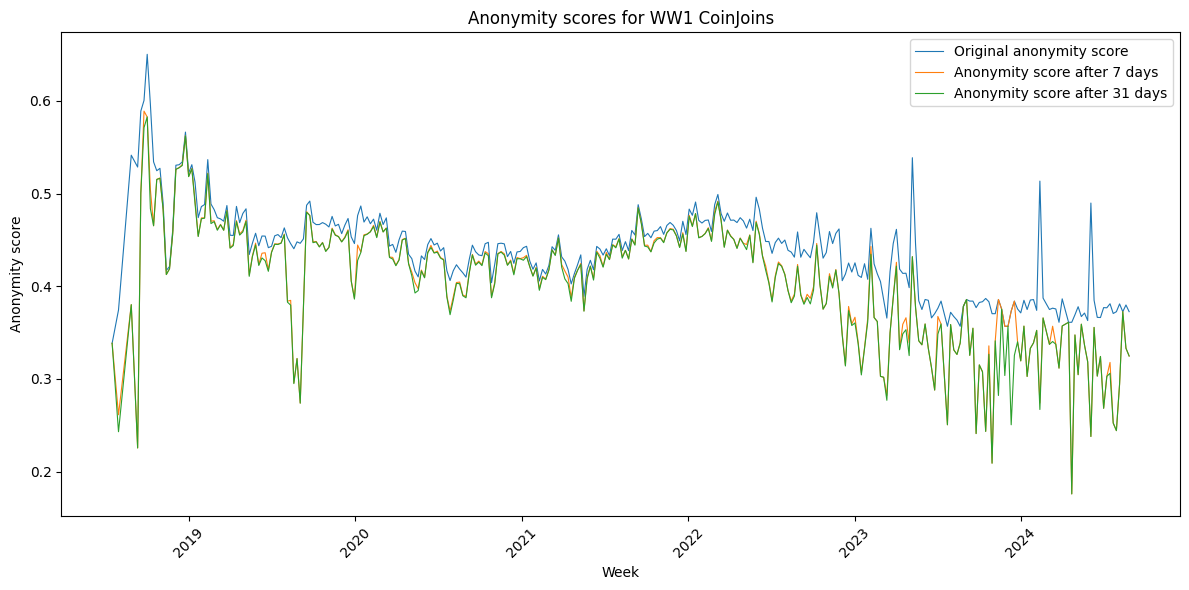

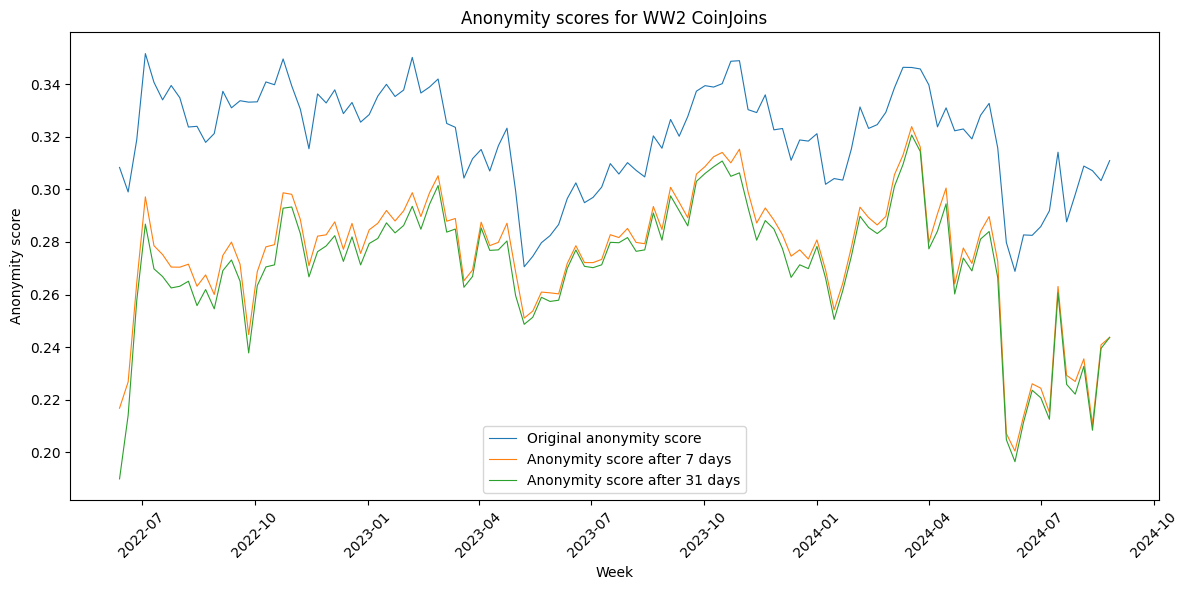

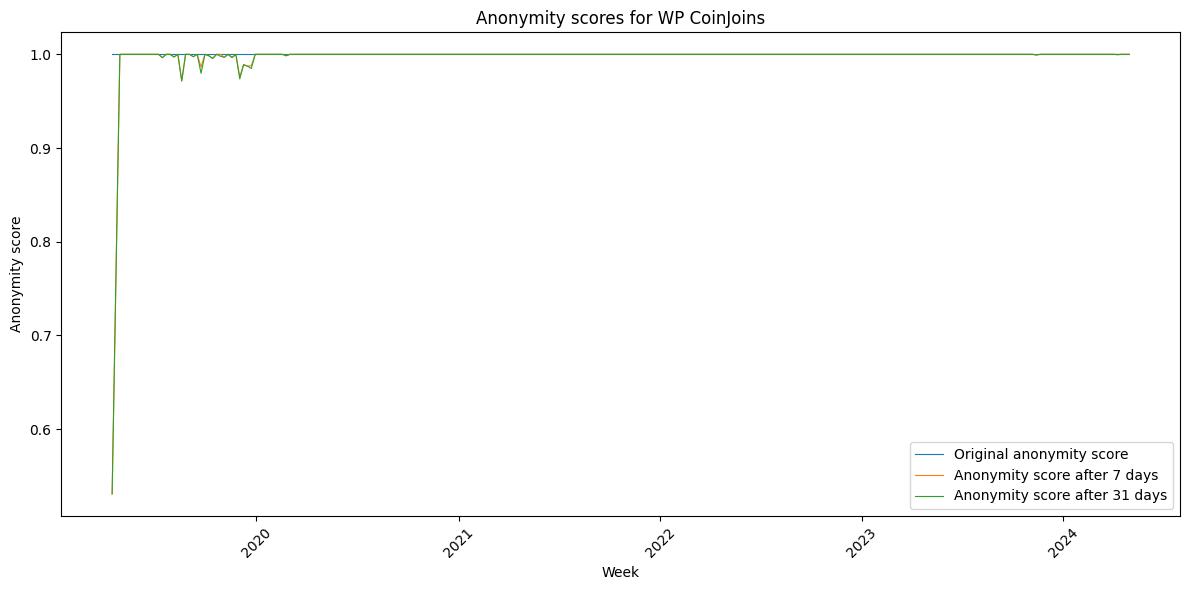

In [7]:
plot_anonymity_degradation(ww1_original_data, ww1_after_week_data, ww1_after_month_data, "WW1")
plot_anonymity_degradation(ww2_original_data, ww2_after_week_data, ww2_after_month_data, "WW2")
plot_anonymity_degradation(wp_original_data, wp_after_week_data, wp_after_month_data, "WP")

CPU times: user 2min 30s, sys: 43.2 s, total: 3min 13s
Wall time: 2.42 s
CPU times: user 3min 39s, sys: 380 ms, total: 3min 39s
Wall time: 6.68 s
CPU times: user 3min 43s, sys: 342 ms, total: 3min 43s
Wall time: 7.11 s


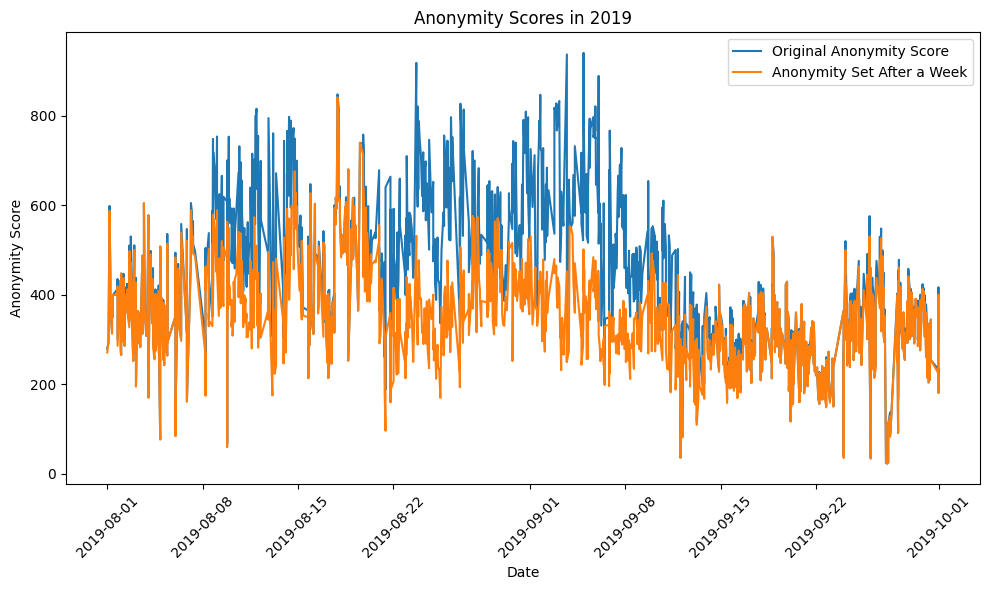

In [3]:
import pandas as pd

%time original_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww1", 0)
%time after_week_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww1", 7)
%time after_month_data = chain.compute_anonymity_degradation_in_coinjoins(0, len(chain), "ww1", 31)


# Convert both dictionaries into DataFrames
df_original = pd.DataFrame(
    [(transaction.block_time, count) for transaction, count in original_data.items()],
    columns=["block_time", "original_anonymity_score"],
)

df_after_week = pd.DataFrame(
    [(transaction.block_time, count) for transaction, count in after_week_data.items()],
    columns=["block_time", "anonymity_set_after_week"],
)

# Convert block_time to datetime
df_original["block_time"] = pd.to_datetime(df_original["block_time"])
df_after_week["block_time"] = pd.to_datetime(df_after_week["block_time"])

# Merge the two datasets
df = pd.merge(df_original, df_after_week, on="block_time", how="outer")

# Filter rows for 2019
df_original = df_original[
    (df_original['block_time'] >= '2019-08-01') & (df_original['block_time'] < '2019-10-01')
].sort_values(by="block_time")
df_after_week = df_after_week[
    (df_after_week['block_time'] >= '2019-08-01') & (df_after_week['block_time'] < '2019-10-01')
].sort_values(by="block_time")

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(
    df_original["block_time"],
    df_original["original_anonymity_score"],
    label="Original Anonymity Score",
)
plt.plot(
    df_after_week["block_time"],
    df_after_week["anonymity_set_after_week"],
    label="Anonymity Set After a Week",
)

plt.xlabel("Date")
plt.ylabel("Anonymity Score")
plt.title("Anonymity Scores in 2019")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
%time ww1_original_data = chain.compute_anonymity_degradation_in_coinjoins_from_joining_txes(0, len(chain), "ww1", 0)
%time ww1_after_week_data = chain.compute_anonymity_degradation_in_coinjoins_from_joining_txes(0, len(chain), "ww1", 7)
%time ww1_after_month_data = chain.compute_anonymity_degradation_in_coinjoins_from_joining_txes(0, len(chain), "ww1", 31)

plot_anonymity_degradation(ww1_original_data, ww1_after_week_data, ww1_after_month_data, "ww1_extra")
